## Airbnb: Who owns what?


The dataset for this exercise is all retrieved from [Inside Airbnb](https://insideairbnb.com/), which is a mission driven project hat provides data and advocacy about Airbnb's impact on residential communities.

Even though Airbnb does not provide public statistics, **Inside Airbnb** utilizes public information compiled from the Airbnb web-site including the availabiity calendar for 365 days in the future, and the reviews for each listing. This data has already gone through a process of cleansing, verification and aggregation, so we'll make an initial exploration but will focus mainly on identifying tendencies and data behaviour. 
We'll put especial atention in see how much does Airbnb complies with its proclaimed mission of contribuiting to shared economy and disrupting the hotel industry  

We'll work with 3 big cities (Barcelona, Buenos Aires, Mexico City ) to identify similar behaviours and patterns. We'll start with Barcelona and then replicate the analysis in the other two

In [633]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Inside Airbnb ofrece un dataset de todas las ofertas listadas curadas y uno previo al procesamiento. Empezaremos por el listado curado y luego exploraremos el original para considerar datos que hayan podido ser dejados de lado por Inside Airbnb pero puedan ser pertinentes 

Daremos una mirada a las primeras filas del dataset para proceder a observar el tipo de dato de cada columna, para identificar todos los datos que podremos encontrar

In [634]:
barcelona= pd.read_csv('data/barcelona/listings.csv')
barcelona.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia Maria,Eixample,la Sagrada Família,41.405560,2.17262,Entire home/apt,194.0,1,42,2024-06-03,0.31,28,72,3,HUTB-002062
1,23197,"Forum CCIB DeLuxe, Spacious, Large Balcony, relax",90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.412432,2.21975,Entire home/apt,304.0,3,79,2024-06-24,0.48,1,116,7,HUTB005057
2,32711,Sagrada Familia area - Còrsega 1,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.405660,2.17015,Entire home/apt,211.0,1,128,2024-09-05,0.80,3,319,32,HUTB-001722
3,34241,Stylish Top Floor Apartment - Ramblas Plaza Real,73163,Andres,Ciutat Vella,el Barri Gòtic,41.380620,2.17517,Entire home/apt,300.0,5,20,2024-08-20,0.12,3,69,12,Exempt
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.379780,2.17623,Entire home/apt,314.0,5,247,2024-09-02,1.46,3,241,37,HUTB-150671


In [635]:
barcelona.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object

Hecho esto, procederemos ahora a buscar datos faltantes, incompletos, o alquileres (listings) repetidos 

In [636]:
barcelona.shape


(19482, 18)

In [637]:
barcelona.count()

id                                19482
name                              19482
host_id                           19482
host_name                         19480
neighbourhood_group               19482
neighbourhood                     19482
latitude                          19482
longitude                         19482
room_type                         19482
price                             15422
minimum_nights                    19482
number_of_reviews                 19482
last_review                       14731
reviews_per_month                 14731
calculated_host_listings_count    19482
availability_365                  19482
number_of_reviews_ltm             19482
license                           13288
dtype: int64

In [638]:
barcelona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19482 non-null  int64  
 1   name                            19482 non-null  object 
 2   host_id                         19482 non-null  int64  
 3   host_name                       19480 non-null  object 
 4   neighbourhood_group             19482 non-null  object 
 5   neighbourhood                   19482 non-null  object 
 6   latitude                        19482 non-null  float64
 7   longitude                       19482 non-null  float64
 8   room_type                       19482 non-null  object 
 9   price                           15422 non-null  float64
 10  minimum_nights                  19482 non-null  int64  
 11  number_of_reviews               19482 non-null  int64  
 12  last_review                     

Ya podemos observar varias columnas con datos incompletos: price, last_review, reviews_per_month, license. 
- El dato de licencia ya observamos que es de tipo object, brindando la referencia de licencia de cada alquiler, irrelevante para nuestro caso, podemos descartarlo. 
- El precio podría ser relevante para nuestro análisis, pero para reemplazarlo tendríamos que hacer una distinción del tipo de alquiler que ofrece (vivienda completa, habitación compartida, habitación privada) para hacer un manejo de estos valores nulos sin tergiversar los datos
- El dato de última reseña si bien está parseado como object corresponde a una fecha, pero
- El número de reseñas por mes es significativo, sin embargo en este caso, para evitar suposiciones que sesgen el análisis podemos apoyarnos en el dato de número de reseñas del último semestre. Al faltar este dato en casi el 25% del dataset considero más fidedigno descartar este dato que descartar los alquileres faltantes de este valor, por lo que procederemos también a descartar esta columna. 

Antes de resolver los valores nulos de precios vamos a revisar la uniformidad de datos en el tipo de habitación, para apoyarnos en este dato y hacer un reemplazo de valores nulos segmentado 

In [639]:
barcelona['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

Una vez verificamos que los datos de tipo de habitación están estandarizados podemos apoyarnos en estos para reemplazar los valores nulos de pricing con el promedio de el tipo de habitación en cuestión



In [640]:
avg_entire_home = barcelona[barcelona['room_type']=='Entire home/apt']['price'].mean()
avg_private_room = barcelona[barcelona['room_type']=='Private room']['price'].mean()
avg_hotel_room = barcelona[barcelona['room_type']=='Hotel room']['price'].mean()
avg_shared_room = barcelona[barcelona['room_type']=='Shared room']['price'].mean()
replacement_prices = {
    'Entire home/apt':avg_entire_home,
    'Private room':avg_private_room,
    'Hotel room':avg_hotel_room,
    'Shared room':avg_shared_room}


barcelona['price']=barcelona['price'].fillna(barcelona['room_type'].map(replacement_prices))

Chequeamos haber reemplazado efectivamente los datos nulos de precios y procedemos a eliminar las columnas incompletas e irrelevantes de nuestro DF

In [641]:
print(barcelona.columns)
barcelona = barcelona.drop(columns=['last_review','reviews_per_month','license'])
barcelona.info()

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19482 non-null  int64  
 1   name                            19482 non-null  object 
 2   host_id                         19482 non-null  int64  
 3   host_name                       19480 non-null  object 
 4   neighbourhood_group             19482 non-null  object 
 5   neighbourhood                   19482 non-null  object 
 6   latitude                        19482 non-null  fl

In [642]:
barcelona = barcelona.dropna(subset=['number_of_reviews_ltm'])
barcelona['number_of_reviews'].isna().sum()

np.int64(0)

Ahora que eliminamos todos los valores nulos, procedemos a revisar datos inconsistentes o duplicados

In [643]:
barcelona['id'].duplicated().sum()

np.int64(0)

In [644]:
barcelona.duplicated(subset=['name','latitude','longitude']).sum()

np.int64(77)

In [645]:
barcelona[barcelona.duplicated(subset=['name','latitude','longitude'], keep=False)]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
189,721511,Beautiful apt with private terrace near to Sag...,3724467,EasySleep,Eixample,la Dreta de l'Eixample,41.397950,2.170300,Entire home/apt,229.000000,3,107,12,100,30
190,721512,Beautiful apt with private terrace near to Sag...,3724467,EasySleep,Eixample,la Dreta de l'Eixample,41.397950,2.170300,Entire home/apt,229.000000,3,4,12,106,0
2221,9378710,Art Gallery Apartment 4,4396136,Homesearch,Sants-Montjuïc,el Poble Sec,41.374490,2.163360,Entire home/apt,193.000000,3,29,30,25,2
3485,18748079,Superior three bedroom Apartment,113020313,Javier,Gràcia,la Vila de Gràcia,41.399930,2.156540,Entire home/apt,222.000000,1,61,10,70,9
3486,18748083,Superior three bedroom Apartment,113020313,Javier,Gràcia,la Vila de Gràcia,41.399930,2.156540,Entire home/apt,222.000000,1,19,10,71,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17950,1162224551723781140,Habitación Doble con Balcón,449485386,Joaquín,Sant Andreu,el Congrés i els Indians,41.423286,2.181631,Private room,81.988275,32,0,74,5,0
17952,1162242734301888793,Habitación Doble con Balcón,449485386,Joaquín,Sant Andreu,el Congrés i els Indians,41.423286,2.181631,Private room,81.988275,32,0,74,0,0
18292,1180161973371834422,Colorist apartment in the center minimum 32 ni...,368317,Nacharosa,Ciutat Vella,el Raval,41.381543,2.164932,Entire home/apt,60.000000,31,0,11,365,0
18293,1180176043188073820,Colorist apartment in the center minimum 32 ni...,368317,Nacharosa,Ciutat Vella,el Raval,41.381543,2.164932,Entire home/apt,60.000000,31,0,11,332,0


In [646]:
barcelona.duplicated(subset=['name','latitude','longitude','host_id','neighbourhood_group','neighbourhood','room_type','price'], keep=False).sum()

np.int64(57)

In [647]:
barcelona[barcelona.duplicated(subset=['name','latitude','longitude','host_id','host_name','neighbourhood_group','neighbourhood','room_type','price'], keep=False)]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
189,721511,Beautiful apt with private terrace near to Sag...,3724467,EasySleep,Eixample,la Dreta de l'Eixample,41.397950,2.170300,Entire home/apt,229.000000,3,107,12,100,30
190,721512,Beautiful apt with private terrace near to Sag...,3724467,EasySleep,Eixample,la Dreta de l'Eixample,41.397950,2.170300,Entire home/apt,229.000000,3,4,12,106,0
3485,18748079,Superior three bedroom Apartment,113020313,Javier,Gràcia,la Vila de Gràcia,41.399930,2.156540,Entire home/apt,222.000000,1,61,10,70,9
3486,18748083,Superior three bedroom Apartment,113020313,Javier,Gràcia,la Vila de Gràcia,41.399930,2.156540,Entire home/apt,222.000000,1,19,10,71,0
3748,19779264,COZY STUDIO 2 PAX IN BORN,139063900,Deco Apartments Barcelona,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.384827,2.183088,Entire home/apt,208.901147,1,338,36,0,19
3905,20486551,COMFORTABLE THREE BEDROOM APARTMENT,139063900,Deco Apartments Barcelona,Sants-Montjuïc,Hostafrancs,41.374531,2.143429,Entire home/apt,216.000000,1,198,36,165,56
3906,20486557,TWO BEDROOM APARTMENT,139063900,Deco Apartments Barcelona,Sants-Montjuïc,Hostafrancs,41.374352,2.143439,Entire home/apt,168.000000,1,121,36,203,27
4082,21410162,PREMIUM ONE BEDROOM APARTMENT,139063900,Deco Apartments Barcelona,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.384235,2.183663,Entire home/apt,256.000000,1,65,36,40,13
4136,21653699,PREMIUM ONE BEDROOM APARTMENT,139063900,Deco Apartments Barcelona,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.384235,2.183663,Entire home/apt,256.000000,1,183,36,37,39
4138,21653707,PREMIUM ONE BEDROOM APARTMENT,139063900,Deco Apartments Barcelona,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.384235,2.183663,Entire home/apt,256.000000,1,144,36,65,39


In [648]:
pd.concat([barcelona, barcelona.duplicated(subset=['name','latitude','longitude','host_id','neighbourhood_group','neighbourhood','room_type','price'], keep=False),barcelona[barcelona.duplicated(subset=['name','latitude','longitude'], keep=False)]]).drop_duplicates(keep=False)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,0
0,1.867400e+04,Huge flat for 8 people close to Sagrada Familia,71615.0,Mireia Maria,Eixample,la Sagrada Família,41.405560,2.172620,Entire home/apt,194.0,1.0,42.0,28.0,72.0,3.0,NaN
1,2.319700e+04,"Forum CCIB DeLuxe, Spacious, Large Balcony, relax",90417.0,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.412432,2.219750,Entire home/apt,304.0,3.0,79.0,1.0,116.0,7.0,NaN
2,3.271100e+04,Sagrada Familia area - Còrsega 1,135703.0,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.405660,2.170150,Entire home/apt,211.0,1.0,128.0,3.0,319.0,32.0,NaN
3,3.424100e+04,Stylish Top Floor Apartment - Ramblas Plaza Real,73163.0,Andres,Ciutat Vella,el Barri Gòtic,41.380620,2.175170,Entire home/apt,300.0,5.0,20.0,3.0,69.0,12.0,NaN
4,3.498100e+04,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163.0,Andres,Ciutat Vella,el Barri Gòtic,41.379780,2.176230,Entire home/apt,314.0,5.0,247.0,3.0,241.0,37.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19477,1.229495e+18,Luxurious Apartment with Private Gym in Barcelona,250042982.0,HiGuests,Eixample,la Dreta de l'Eixample,41.392830,2.175632,Entire home/apt,138.0,32.0,0.0,48.0,353.0,0.0,NaN
19478,1.229566e+18,Una Bonita Habitación Para Tres,575003839.0,Carlos Alberto,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.386560,2.175730,Private room,104.0,1.0,0.0,17.0,357.0,0.0,NaN
19479,1.229569e+18,Comoda Habitación Doble,575003839.0,Carlos Alberto,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.386720,2.176880,Private room,65.0,1.0,0.0,17.0,359.0,0.0,NaN
19480,1.229579e+18,Bonita Habitación Doble,575003839.0,Carlos Alberto,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.386933,2.175837,Private room,60.0,1.0,0.0,17.0,355.0,0.0,NaN


Guiándonos por el id de cada alquiler parecería que no hay datos repetidos, observando datos que deberían ser únicos (nombre y ubicación) vemos que por el contrario si hay datos repetidos, ya que al observar la tabla -y verificando con pandas- vemos que no solo coinciden con exactitud el nombre y ubicación (latitud y longitud), sino que para 57 registros también lo son vencindario, id del host, tipo de habitación y precio.
Esto podría deberse a un doble registro o a errores en el scraping, pero es asumible que los registros corresponden al mismo alquiler.

Observando en detalle podemos identificar que la única diferencia entre los registros repetidos es el número de reseñas y la cantidad de reseñas del último semestre, que parecieran repetirse entre los registros duplicados. Para evitar este dato que podría ser relevante resolvemos sumar las reseñas de propiedades idénticas y proceder a eliminar los registros duplicados

Para esto vamos a agrupar por propiedad con datos idénticos y sumar sus reseñas. En este proceso descartaremos los ids de cada propiedad, que recuperaremos una vez sumemos las reseñas y eliminemos ids de alquileres duplicados

In [649]:
barcelona_non_duplicates = barcelona.groupby(['name','latitude','longitude','host_id','host_name','neighbourhood_group','neighbourhood','room_type','price'], as_index=False)[['number_of_reviews','number_of_reviews_ltm']].sum()

In [650]:
barcelona_non_duplicates.duplicated(subset=['name','latitude','longitude','host_id','host_name','neighbourhood_group','neighbourhood','room_type','price'], keep=False).sum()

np.int64(0)

In [651]:
barcelona_unique_ids = barcelona.drop_duplicates(subset=['name','latitude','longitude','host_id','host_name','neighbourhood_group','neighbourhood','room_type','price'], keep='first')[['id','name','latitude','longitude','host_id','host_name','neighbourhood_group','neighbourhood','room_type','price','calculated_host_listings_count','availability_365']]
barcelona = barcelona_unique_ids.merge(barcelona_non_duplicates, on=['name','latitude','longitude','host_id','host_name','neighbourhood_group','neighbourhood','room_type','price'], how='left')
barcelona

,id,name,latitude,longitude,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,calculated_host_listings_count,availability_365,number_of_reviews,number_of_reviews_ltm
0,18674,Huge flat for 8 people close to Sagrada Familia,41.405560,2.172620,71615,Mireia Maria,Eixample,la Sagrada Família,Entire home/apt,194.0,28,72,42.0,3.0
1,23197,"Forum CCIB DeLuxe, Spacious, Large Balcony, relax",41.412432,2.219750,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,Entire home/apt,304.0,1,116,79.0,7.0
2,32711,Sagrada Familia area - Còrsega 1,41.405660,2.170150,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,Entire home/apt,211.0,3,319,128.0,32.0
3,34241,Stylish Top Floor Apartment - Ramblas Plaza Real,41.380620,2.175170,73163,Andres,Ciutat Vella,el Barri Gòtic,Entire home/apt,300.0,3,69,20.0,12.0
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,41.379780,2.176230,73163,Andres,Ciutat Vella,el Barri Gòtic,Entire home/apt,314.0,3,241,247.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19442,1229494875568799521,Luxurious Apartment with Private Gym in Barcelona,41.392830,2.175632,250042982,HiGuests,Eixample,la Dreta de l'Eixample,Entire home/apt,138.0,48,353,0.0,0.0
19443,1229565507103158854,Una Bonita Habitación Para Tres,41.386560,2.175730,575003839,Carlos Alberto,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",Private room,104.0,17,357,0.0,0.0
19444,1229569436604812436,Comoda Habitación Doble,41.386720,2.176880,575003839,Carlos Alberto,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",Private room,65.0,17,359,0.0,0.0
19445,1229579149869166701,Bonita Habitación Doble,41.386933,2.175837,575003839,Carlos Alberto,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",Private room,60.0,17,355,0.0,0.0


Una vez eliminados posibles duplicados verificamos consistencia de los datos

In [652]:
barcelona['latitude'].max()

np.float64(41.4563771)

In [653]:
barcelona['longitude'].max()

np.float64(2.22771)

Verificamos que los valores de latitud/longitud estén dentro de los rangos estandar

<Axes: xlabel='latitude', ylabel='longitude'>

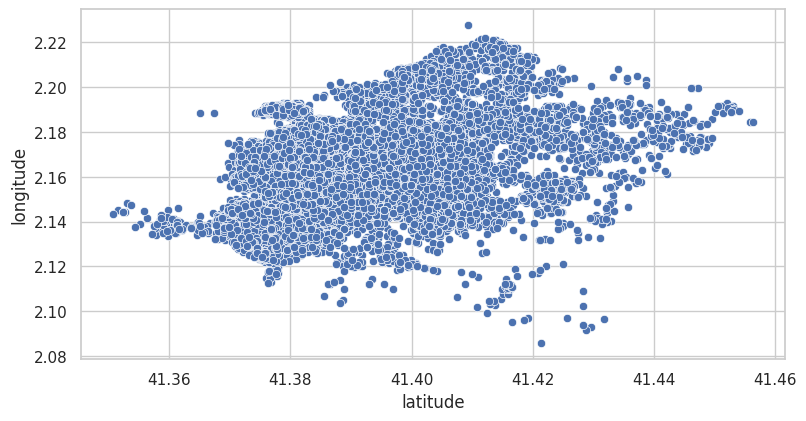

In [654]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.scatterplot(x='latitude', y='longitude', data=barcelona)

In [655]:
barcelona.price.max()

np.float64(9999.0)

In [656]:
barcelona.price.min()

np.float64(8.0)

In [657]:
barcelona.price.mean()

np.float64(158.38588743858583)

<Axes: xlabel='room_type', ylabel='price'>

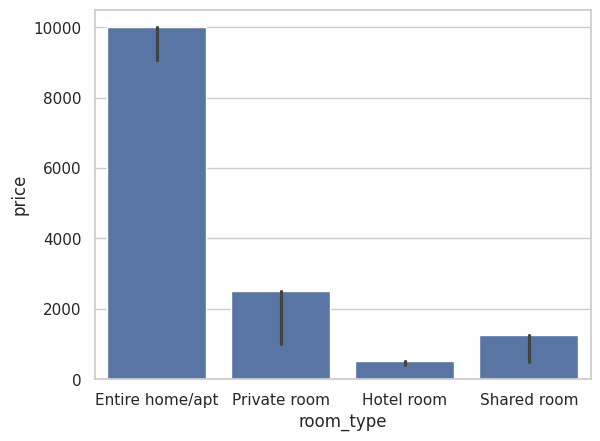

In [658]:
sns.barplot(x='room_type', y='price', data=barcelona, estimator=np.max)

Aunque observamos una diferencia significativa entre el precio más alto y la media de precios al desagregar por tipo de vivienda vemos que los precios más altos corresponden a viviendas enteras y están dentro de los estándares del mercado, por lo que podemos considerar los valores como válidos.

Pasamos ahora a verificar la integridad de los números de reseñas

In [659]:
barcelona['number_of_reviews_ltm'].unique()

array([3.000e+00, 7.000e+00, 3.200e+01, 1.200e+01, 3.700e+01, 0.000e+00,
       2.000e+00, 5.600e+01, 2.000e+01, 2.900e+01, 1.000e+00, 1.200e+02,
       2.800e+01, 1.900e+01, 1.300e+01, 4.500e+01, 2.500e+01, 1.500e+01,
       1.100e+01, 3.800e+01, 4.000e+00, 1.800e+01, 8.000e+00, 3.400e+01,
       2.100e+01, 1.600e+01, 5.500e+01, 3.100e+01, 2.300e+01, 4.200e+01,
       2.700e+01, 3.300e+01, 2.400e+01, 4.300e+01, 4.000e+01, 4.800e+01,
       6.800e+01, 2.200e+01, 3.000e+01, 4.900e+01, 7.100e+01, 5.200e+01,
       9.000e+00, 7.700e+01, 6.500e+01, 4.700e+01, 6.200e+01, 8.100e+01,
       4.100e+01, 2.600e+01, 3.500e+01, 6.000e+00, 3.900e+01, 5.000e+00,
       5.700e+01, 4.600e+01, 1.700e+01, 4.400e+01, 1.400e+01, 1.000e+01,
       6.400e+01, 5.000e+01, 7.300e+01, 5.100e+01, 7.500e+01, 8.200e+01,
       2.040e+02, 1.800e+02, 6.000e+01, 6.100e+01, 1.060e+02, 3.600e+01,
       1.040e+02, 7.400e+01, 5.300e+01, 5.800e+01, 5.400e+01, 8.700e+01,
       7.000e+01, 6.600e+01, 1.300e+02, 5.900e+01, 

In [660]:
barcelona['number_of_reviews_ltm'].max()

np.float64(1287.0)

Podemos ver que hay propiedades con más de 365 reseñas en el último mes. Esto puede correspondere a propiedades que permiten distintos huéspedes, pero no tenemos certeza de eso y podría perjudicar nuestro análisis. Para evitar desviaciones procedemos a descartar esos registros

In [661]:
barcelona = barcelona.drop(barcelona[barcelona['number_of_reviews_ltm'] >365].index)
barcelona.count()

id                                19441
name                              19441
latitude                          19441
longitude                         19441
host_id                           19441
host_name                         19439
neighbourhood_group               19441
neighbourhood                     19441
room_type                         19441
price                             19441
calculated_host_listings_count    19441
availability_365                  19441
number_of_reviews                 19439
number_of_reviews_ltm             19439
dtype: int64

In [662]:
barcelona['number_of_reviews'].max()

np.float64(2132.0)

Text(0.5, 1.0, 'Número de reseñas totales')

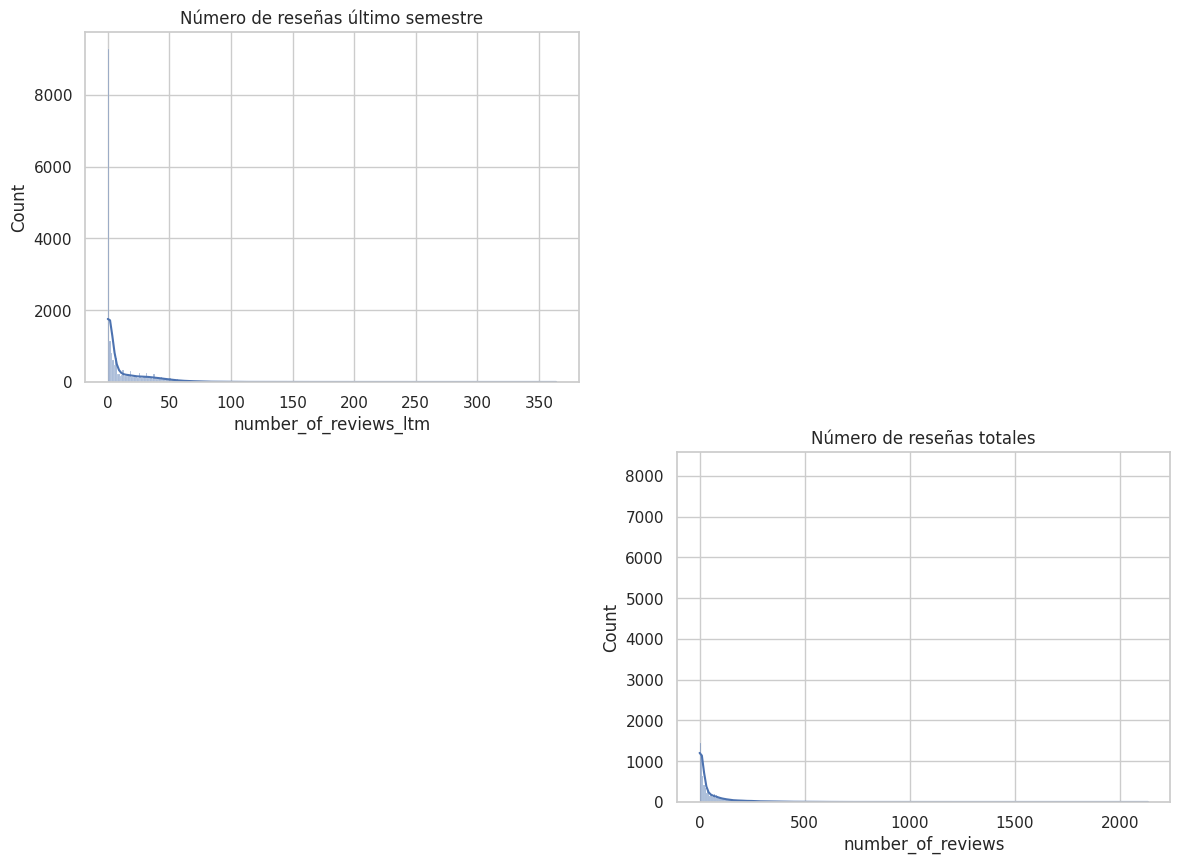

In [663]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.set(style="whitegrid")
sns.histplot(barcelona['number_of_reviews_ltm'], kde=True)
plt.title('Número de reseñas último semestre')


plt.subplot(2, 2, 4)
plt.subplot(2, 2, 4)
sns.histplot(barcelona['number_of_reviews'], kde=True)
plt.title('Número de reseñas totales')


(0.0, 2000.0)

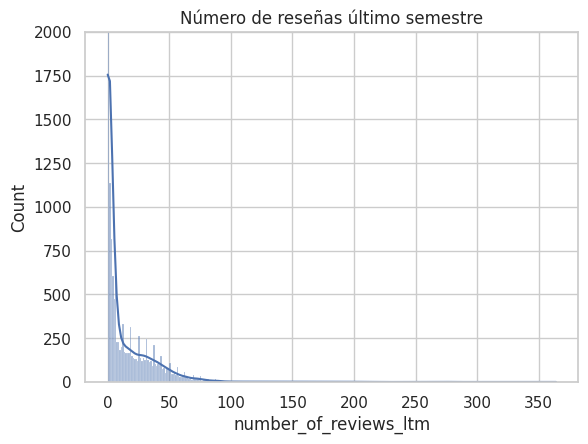

In [664]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
graph_total_reviews_ltm= sns.histplot(barcelona['number_of_reviews_ltm'], kde=True)
plt.title('Número de reseñas último semestre')
graph_total_reviews_ltm.set_ylim(0, 2000)




Si bien hay una variación significativa entre el número de reseñas que tienen un alto número de reseñas y los que no tienen ninguna, son valores estándares en el comportamiento que observamos en la plataforma, por lo que consideramos válidos estos valores.

In [665]:
barcelona['availability_365'].describe()

count    19441.000000
mean       177.156113
std        125.361826
min          0.000000
25%         59.000000
50%        183.000000
75%        300.000000
max        365.000000
Name: availability_365, dtype: float64

Ahora procedemos a observar el comportamiento de las columnas más relevantes

In [666]:
barcelona['room_type'].describe()

count               19441
unique                  4
top       Entire home/apt
freq                11566
Name: room_type, dtype: object

Text(0.5, 0, 'Room type')

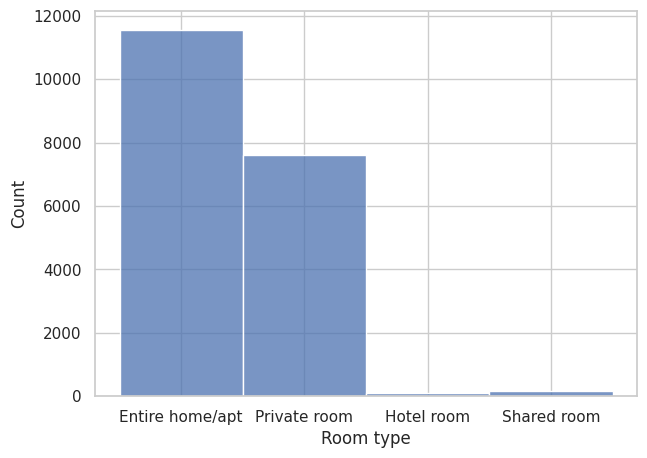

In [667]:
plt.figure(figsize=(7, 5))
sns.set(style="whitegrid")
sns.histplot(barcelona['room_type'])
plt.xlabel('Room type')

In [668]:
barcelona['room_type'].value_counts()

room_type
Entire home/apt    11566
Private room        7599
Shared room          159
Hotel room           117
Name: count, dtype: int64

A partir de la gráfica y de una cuenta de valores de cada tipo de habitación podemos observar una significativa tendencia a los alquileres de vivienda entera, representando estos casi el doble de las habitaciones privadas y más de 50 veces las habitaciones compartidas

In [669]:
barcelona_max_price_count = barcelona['price'].value_counts().max()
print(barcelona_max_price_count)

2826


In [670]:
barcelona_max_price = barcelona['price'].max()
print(barcelona_max_price)

9999.0


(0.0, 10998.900000000001)

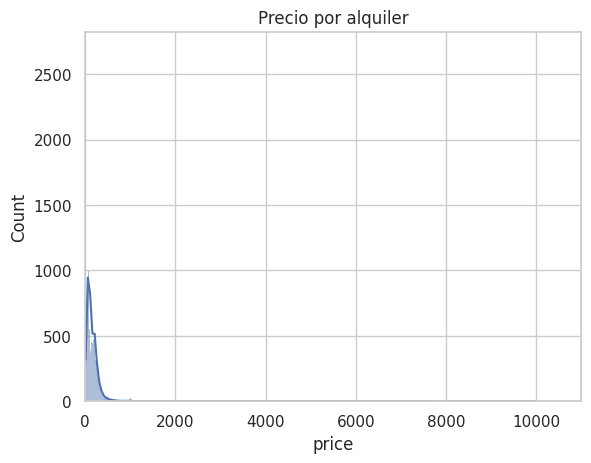

In [671]:
graph_price = sns.histplot(barcelona['price'], kde=True)
plt.title('Precio por alquiler')
graph_price.set_ylim(0, barcelona_max_price_count)
graph_price.set_xlim(0, barcelona_max_price*1.1)

Text(0.5, 1.0, 'Disponibilidad en el año')

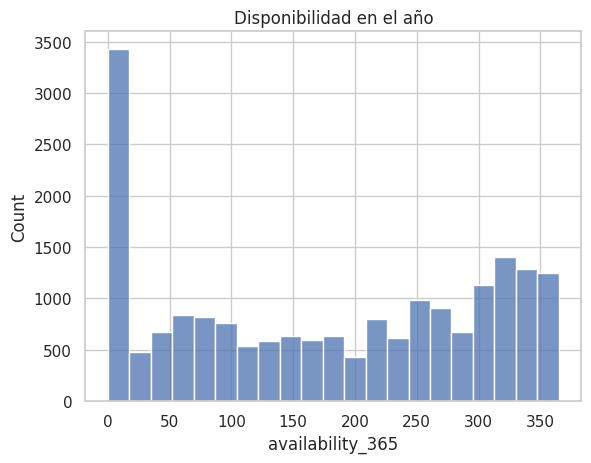

In [672]:
sns.histplot(barcelona['availability_365'])
plt.title('Disponibilidad en el año')

In [673]:
barcelona['calculated_host_listings_count'].describe()

count    19441.000000
mean        41.383777
std         88.526220
min          1.000000
25%          1.000000
50%          6.000000
75%         33.000000
max        437.000000
Name: calculated_host_listings_count, dtype: float64

Text(0.5, 1.0, 'Cantidad de alquileres registrados por dueño')

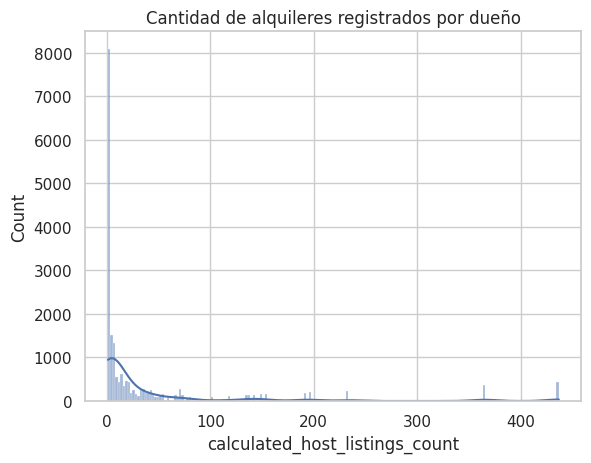

In [674]:
sns.histplot(barcelona['calculated_host_listings_count'], kde=True)
plt.title('Cantidad de alquileres registrados por dueño')

Este es el dato que mas nos va a interesar, sin embargo al provenir de un data set con registros duplicados y al estar repetido por cada alquiler de un mismo dueño optaremos por descartarlo y calcularlo sobre nuestro dataset limpio agrupando los alquileres por dueño y calculando cuantos alquileres efectivos encontramos registrados.  

In [675]:
barcelona.drop(columns=['calculated_host_listings_count'], inplace=True)

Una vez observadas las columnas más relevantes procedemos a desglosar nuestro dataset en dimensiones para un mejor manejo
- Hosts
- Properties
- Neighborhoods
- Rent statistics


In [676]:
hosts =barcelona.groupby(['host_id', 'host_name']).size().reset_index(name='total_properties').sort_values('total_properties', ascending=False)
hosts

,host_id,host_name,total_properties
5686,346367515,Ukio,437
5729,357946540,Enter,365
250,1447144,Acomodis Apartments,233
2451,32037490,SweetInn,195
738,4459553,AB Apartment Barcelona,191
...,...,...,...
7223,594346076,Marta,1
7222,593757281,Enrique,1
7221,593590594,Alicia,1
7218,593488327,Enrique,1


In [677]:
hosts.to_csv('data/results/dim_hosts.csv', index=False)

In [678]:
properties = barcelona[['id', 'name', 'latitude', 'longitude', 'host_id', 'neighbourhood', 'room_type', 'price', 'availability_365']]
properties

,id,name,latitude,longitude,host_id,neighbourhood,room_type,price,availability_365
0,18674,Huge flat for 8 people close to Sagrada Familia,41.405560,2.172620,71615,la Sagrada Família,Entire home/apt,194.0,72
1,23197,"Forum CCIB DeLuxe, Spacious, Large Balcony, relax",41.412432,2.219750,90417,el Besòs i el Maresme,Entire home/apt,304.0,116
2,32711,Sagrada Familia area - Còrsega 1,41.405660,2.170150,135703,el Camp d'en Grassot i Gràcia Nova,Entire home/apt,211.0,319
3,34241,Stylish Top Floor Apartment - Ramblas Plaza Real,41.380620,2.175170,73163,el Barri Gòtic,Entire home/apt,300.0,69
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,41.379780,2.176230,73163,el Barri Gòtic,Entire home/apt,314.0,241
...,...,...,...,...,...,...,...,...,...
19442,1229494875568799521,Luxurious Apartment with Private Gym in Barcelona,41.392830,2.175632,250042982,la Dreta de l'Eixample,Entire home/apt,138.0,353
19443,1229565507103158854,Una Bonita Habitación Para Tres,41.386560,2.175730,575003839,"Sant Pere, Santa Caterina i la Ribera",Private room,104.0,357
19444,1229569436604812436,Comoda Habitación Doble,41.386720,2.176880,575003839,"Sant Pere, Santa Caterina i la Ribera",Private room,65.0,359
19445,1229579149869166701,Bonita Habitación Doble,41.386933,2.175837,575003839,"Sant Pere, Santa Caterina i la Ribera",Private room,60.0,355


In [679]:
properties.to_csv('data/results/dim_properties.csv', index=False)

In [680]:
neighborhoods = barcelona.groupby(['neighbourhood', 'neighbourhood_group']).size().reset_index(name='total_properties').sort_values('total_properties', ascending=False)
neighborhoods

,neighbourhood,neighbourhood_group,total_properties
49,la Dreta de l'Eixample,Eixample,2354
43,el Raval,Ciutat Vella,1555
28,el Barri Gòtic,Ciutat Vella,1264
18,"Sant Pere, Santa Caterina i la Ribera",Ciutat Vella,1216
58,la Sagrada Família,Eixample,1136
...,...,...,...
48,la Clota,Horta-Guinardó,5
0,Baró de Viver,Sant Andreu,3
2,Can Peguera,Nou Barris,2
3,Canyelles,Nou Barris,2


In [681]:
neighborhoods.to_csv('data/results/dim_neighborhoods.csv', index=False)

In [682]:
# barcelona
rent_stats= barcelona[['id','host_id', 'availability_365','number_of_reviews_ltm']].sort_values('number_of_reviews_ltm', ascending=False)
rent_stats

,id,host_id,availability_365,number_of_reviews_ltm
6875,39404484,4258623,312,364.0
5544,30759793,228209547,300,339.0
9167,51201977,413277396,349,328.0
6259,35118964,9171437,352,314.0
9723,53411031,432139206,223,306.0
...,...,...,...,...
11,68547,340570,363,0.0
19382,1234633310288552263,566719079,356,0.0
19396,1235499877173440676,460923619,107,0.0
1905,7711359,2550257,0,NaN


In [683]:
rent_stats.to_csv('data/results/fact_rent_stats.csv', index=False)